Testing script for image augmentation

In [1]:
import random

import torch

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, RandomRotation, RandomResizedCrop, ToPILImage, RandomCrop, Resize, RandomPosterize
from torchvision.transforms.functional import invert, adjust_brightness, pil_to_tensor, posterize

import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from copy import deepcopy

from PIL import ImageFont, ImageDraw

import warnings
warnings.filterwarnings("ignore")

In [2]:
def denormalize(tensor):
    return tensor*255.

In [4]:
transform = transforms.ToTensor()
train_kwargs = {'batch_size': 10, 'shuffle':True}
trainset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, **train_kwargs)

Files already downloaded and verified


In [5]:
device = 'cpu'
for batch, (x,y) in enumerate(train_loader):
    x,y = x.to(device), y.to(device)
    break

Test for rotation

In [6]:
rotate = RandomRotation(degrees=(45,60))
indices_to_rotate = random.sample(range(len(x)),2)

In [7]:
indices_to_rotate

[1, 7]

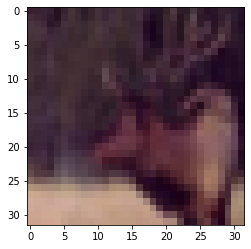

In [8]:
plt.imshow(x[0].permute(1,2,0))

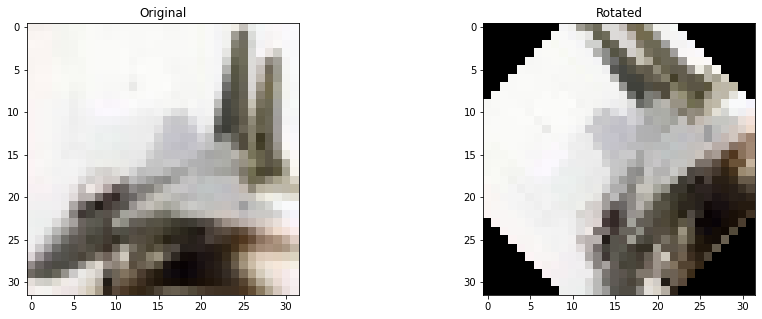

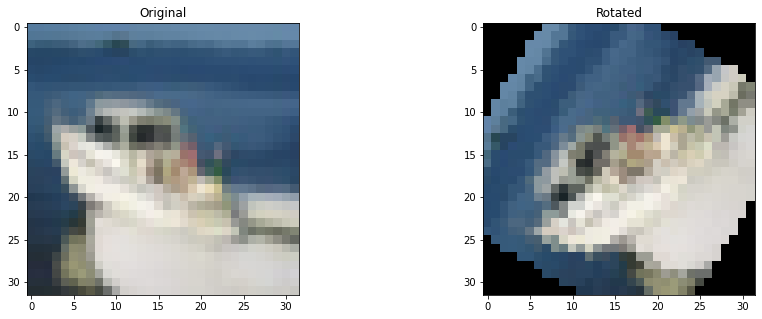

In [9]:
for i in range(len(x)):
    if i in indices_to_rotate:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
        axes[0].imshow(x[i].permute(1,2,0))
        axes[0].set(title = 'Original')
        x[i] = rotate(x[i])
        axes[1].imshow(x[i].permute(1,2,0))
        axes[1].set(title = 'Rotated')

Test for image inversion

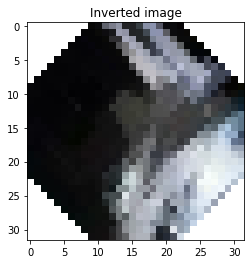

In [10]:
plt.imshow(invert(x[indices_to_rotate[0]]).permute(1,2,0))
plt.title('Inverted image');

Test for lighting change

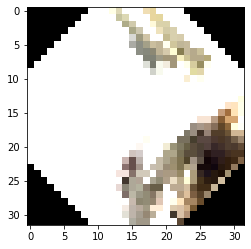

In [11]:
plt.imshow(adjust_brightness(x[indices_to_rotate[0]],2.0).permute(1,2,0))

Test for zooming in 

In [13]:
_,_,shape = next(iter(train_loader))[0][0].shape
shape

32

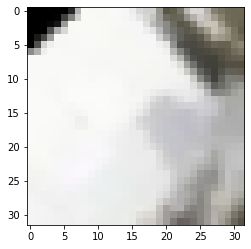

In [14]:
Crop = RandomResizedCrop((shape,shape),(0.2,0.8))
plt.imshow(Crop(x[indices_to_rotate[0]]).permute(1,2,0))

Random cropping

In [15]:
shape

32

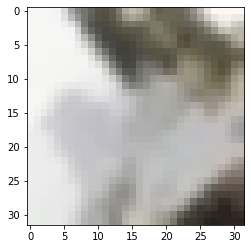

In [16]:
cropper = RandomCrop(size = (16,16))
resize = Resize((shape,shape))
plt.imshow(resize(cropper(x[indices_to_rotate[0]])).permute(1,2,0))

Bitwise depth reduction

In [ ]:
c1 = torch.tensor((x[0]*255).clone(), dtype = torch.uint8)
posterizer = RandomPosterize(bits=2)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(x[0].permute(1,2,0))
axes[0].set(title='Original image')
axes[1].imshow(posterizer(c1).permute(1,2,0))
axes[1].set(title='Feature reduced image')

Gaussian Noise Test

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.5):
        '''
        Reduced the std from 1 to 0.5 because the resultant gaussed image was unrecognizable to humans.
        '''
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
Gauss = AddGaussianNoise(0,0.5)
Gauss

In [ ]:
plt.imshow(Gauss(x[indices_to_rotate[0]]).permute(1,2,0))

Add watermark

In [ ]:
x_w = x_w/255

In [ ]:
plt.imshow(x_w.permute(1,2,0))

In [ ]:
from PIL import ImageFont, ImageDraw

x_w = x[indices_to_rotate[0]].clone()
x_w = ToPILImage()(x[indices_to_rotate[0]].clone().data).convert('RGBA')
draw = ImageDraw.Draw(x_w)
font = ImageFont.truetype("/Library/fonts/Arial.ttf", 5)

draw.text((0, 0), "TADA", 
          (255, 255, 255), font=font)
x_w = pil_to_tensor(x_w)
plt.title("White text")
plt.imshow(x_w.permute(1,2,0))


Add white box

In [ ]:
for i in range(len(x)):
    if i in indices_to_rotate:
        img = ToPILImage()(x[i].clone().data).convert('RGBA')
        draw = ImageDraw.Draw(img)
        draw.rectangle((0, 0, 3, 3), fill=(255, 255, 255))
        img = pil_to_tensor(img)
        img = torch.div(img, 255.0)
        fig,axes = plt.subplots(nrows=1,ncols=2)
        axes[0].imshow(x[i].permute(1,2,0),cmap='gray')
        axes[1].imshow(img.permute(1,2,0))